In [1]:
from pathlib import Path
import numpy as np
import rasterio as rio
from matplotlib import pyplot as plt
from topex import Topex

In [2]:
land_mask = Path('/home/manvel/EO_data/landmask/OSM_ZEE_Iberia_buff.shp')
print(land_mask.is_file())

True


In [4]:
work_dir = Path().cwd()
dem_path = work_dir / 'data/LX_DEM_50m_res.tif'
src = rio.open(dem_path)
dem = src.read(1)
profile = src.profile
# If DEM contains sea, and land area doesn't have 0m values, we can use this
# masking to remove topex effect on the water areas
land_mask = dem==0.
sea_mask = ~land_mask

In [6]:
t = Topex(dem, 2000, 100, y_res=y_res, x_res=x_res)
distances = t._topex_along_axis(dem, 2)

pad_y, pad_x = distances[-1][0], distances[-1][1]
padded_dem = np.pad(dem, ((pad_y,), (pad_x,)))

In [18]:
y_res * distances[5][0] / np.cos(np.pi / 4), x_res / np.sin(np.pi / 4) * distances[5][1]

(629.0134933112662, 602.3131587568521)

In [19]:
distances[5][0], distances[5][1]

(8, 10)

In [3]:
# x_res = 10
# y_res = 15
interval = 100
max_dist = 2000

In [30]:
np.arange(interval, max_dist + interval, interval)

array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000])

In [21]:
pixels_per_interval_axis0 = interval / y_res
pixels_per_interval_axis1 = interval / x_res
pixels_per_interval_axis2_y = interval * np.cos(np.pi/4) / y_res
pixels_per_interval_axis2_x = interval * np.sin(np.pi/4) / x_res

In [18]:
pixels_per_interval_axis0, pixels_per_interval_axis1, pixels_per_interval_axis2_y, pixels_per_interval_axis2_x

(25.0, 50.0, 17.67766952966369, 35.35533905932737)

In [19]:
def _distances(pixels_per_inteval: float) -> np.ndarray:
        '''List of distances to calculate the topex for each location '''
        return (np.arange(1, round(max_dist / interval) + 1
            ) * pixels_per_inteval).round().astype(int)

In [22]:
distances_y = _distances(pixels_per_interval_axis2_y)
distances_x = _distances(pixels_per_interval_axis2_x)
distances_y, distances_x

(array([ 1,  3,  4,  5,  6,  8,  9, 10, 11, 13, 14, 15, 17, 18, 19, 20, 22,
        23, 24, 25]),
 array([ 2,  3,  5,  7,  8, 10, 12, 13, 15, 17, 18, 20, 22, 23, 25, 27, 28,
        30, 32, 33]))

In [35]:
import pandas as pd
df = pd.DataFrame(index=range(len(distances_y)), columns=['average', 'y', 'x'])

for i, y_x in enumerate(zip(distances_y, distances_x)):
    df.iloc[i]['average'] = (y_x[0]*y_res / np.sin(np.pi/4) + y_x[1] *x_res / np.sin(np.pi/4)) / 2
    df.iloc[i]['y'] = y_x[0]*y_res / np.sin(np.pi/4)
    df.iloc[i]['x'] = y_x[1] *x_res / np.sin(np.pi/4)
    # print((y*y_res / np.sin(np.pi/4) +x*x_res / np.sin(np.pi/4)) / 2)

In [16]:
(30*x_res / np.sin(np.pi/4) + 23*y_res / np.sin(np.pi/4)) / 2

1807.6766347702232

In [5]:
def _find_resolution(src):
    assert src.crs, 'Missing or invalid CRS'

    x_res, y_res = src.res

    if src.crs.is_geographic:
        R = 6_371_000  # m (Average Earth radius)
        DEGREE_LENGTH = 2 * np.pi * R / 360
        # image res in meters
        return (y_res * DEGREE_LENGTH,
                x_res * DEGREE_LENGTH * np.cos(np.deg2rad(src.meta['transform'][5])))
    else: # Assuming src.crs.is_projected is True
        return y_res, x_res

resolution_y_x = _find_resolution(src)

In [23]:
R = 6_371_000  # m (Average Earth radius)
DEGREE_LENGTH = 2 * np.pi * R / 360
# image res in meters
# NOTE: In this particular case DEM .tif file is in WGS CRS, not projected
#       And the pixel resolution on both directions are practically the same
src.res

(0.0004999999999999999, 0.0005000000000000006)

In [24]:
res = src.res[1] * DEGREE_LENGTH
max_distance = 2000 # meters. The farthest distance to calculate the max slope. Initial version was 2000m
interval = 100 # meters. The intervals to iteretively chekc for max slope angle

In [25]:
topex = Topex(dem, max_distance, interval, y_res=resolution_y_x[0], x_res=resolution_y_x[1])
topex_all = topex.all_dir_multip() # multiproc w/o shared_memory
topex_name = ['TOPEX_N', 'TOPEX_NE', 'TOPEX_E', 'TOPEX_SE', 'TOPEX_S', 'TOPEX_SW', 'TOPEX_W', 'TOPEX_NW']

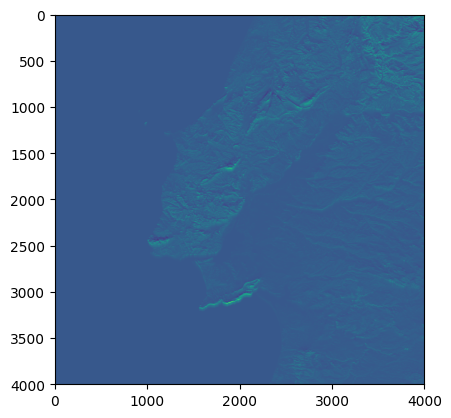

In [14]:
plt.imshow(topex_all[0])

In [7]:
topex = Topex(dem, max_dist, interval, y_res=y_res, x_res=x_res)
topex_se = topex.south_east()

TypeError: Cannot instantiate typing.Union

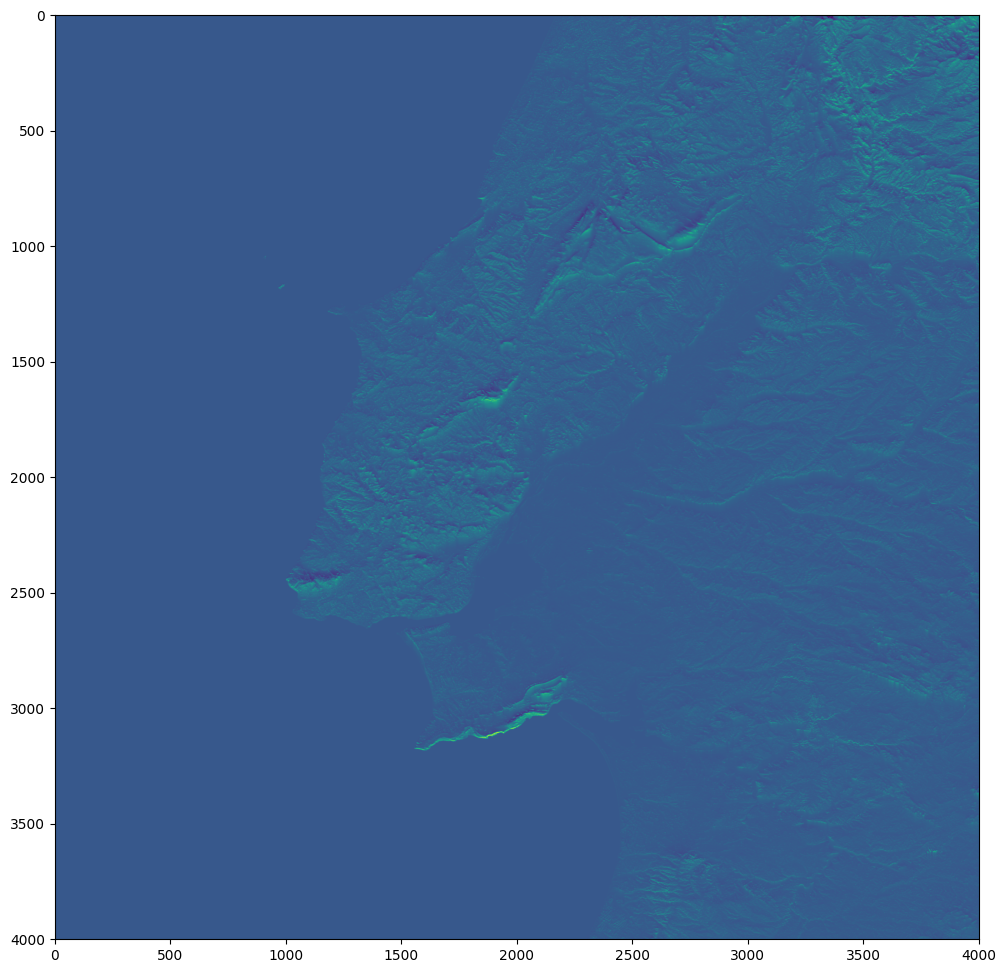

In [22]:
plt.figure(figsize=(12,12))
plt.imshow(topex_all[0])

In [6]:
# Write each TOPEX map in a separate .tif file
profile.update(dtype=rio.float32, count=1)

for topex, name in zip(topex_all, topex_name):
    with rio.open(work_dir / 'results' / f'{name}.tif', 'w', **profile) as dest:
        topex *= sea_mask # Apply sea mask to clean the artifacts
        dest.write(topex, 1)

In [15]:
# Write each TOPEX map in a separate .tif file
profile.update(dtype=rio.float32, count=1)
name = 'topex_SE_brick'
with rio.open(work_dir / 'results/brick' / f'{name}_brick.tif', 'w', **profile) as dest:
    topex_se *= sea_mask # Apply sea mask to clean the artifacts
    dest.write(topex_se, 1)